# Basic Simulation Sample

This notebook contains an implementation of a very simple world simulation built with Neighborly. It demonstrates how to author content starting with the settlement definition and ending with characters.

## Instantiate the simulation

We start by creating a new simulation instance. We can supply a seed value to the configuration to
have the simulation reproduce a similar world. Feel free to uncomment the seed value and try different seeds. If no seed is provided, a random integer seed is generated by the system.This feature is the same as what can be found in Minecraft. Also, we supply a single string for the `settlement` property. This is the ID of the settlement definition to use when generating the world. We create a settlement definition in the next step. Finally, we configure the logging options for the simulation. Currently, it will print out all the world's events as they happen.

In [1]:
from neighborly.simulation import Simulation
from neighborly.config import SimulationConfig, LoggingConfig
from neighborly.plugins import (
    default_events,
    default_character_names,
    default_settlement_names,
    default_traits
)

sim = Simulation(
    SimulationConfig(
        #seed=SimPLeCiTySeEd2023,
        settlement="simple_city",
        logging=LoggingConfig(logging_enabled=False),
    )
)

default_character_names.load_plugin(sim)
default_settlement_names.load_plugin(sim)
default_traits.load_plugin(sim)
default_events.load_plugin(sim)


## Creating Settlements and Districts

Neighborly represents a settlement as a collection of districts, where each district defines what types of businesses, residential buildings, and residents spawn there. Below, we create a single settlement definition and multiple district definitions. One could also define these using external JSON files and load those files into the simulation using the various helper functions found in `neighborly.loaders`.

Settlements spawn districts and districts spawn everything else. Here we have define a single district that can hold a max of three businesses and residential buildings, each. Also, we have provided a single definition ID for each type (residence, business, or character) that can spawn within the district.

In [2]:
from neighborly.defs.defaults import DefaultSettlementDef, DefaultDistrictDef
from neighborly.helpers.settlement import register_district_def, register_settlement_def


# Register our sample settlement definition
register_settlement_def(
    sim.world,
    DefaultSettlementDef(
        definition_id="simple_city",
        display_name="Simple City",
        districts=[
            "main"
        ]
    )
)

# Register a district type
register_district_def(
    sim.world,
    DefaultDistrictDef(
        definition_id="main",
        display_name="Main",
        business_slots=3,
        residential_slots=10,
        residence_types=[
            {
                "definition_id": "house"
            },
            {
                "definition_id": "apartment_building"
            }
        ],
        business_types=[
            {
                "definition_id": "office"
            },
        ],
        character_types=[
            {
                "definition_id": "person"
            }
        ]
    )
)


## Defining residence types

Each residence definition contains parameters for spawning a residential building. These buildings 
contain one or more residential units where individual families live. This representation allows
us to model single and multifamily housing. The type of housing that spawns a district has a direct
affect on the maximum population that the settlement supports. Larger housing means that more people
can spawn into the settlement.

In [3]:
from neighborly.defs.defaults import DefaultResidenceDef
from neighborly.helpers.residence import register_residence_def

register_residence_def(
    sim.world,
    DefaultResidenceDef(
        definition_id="house",
        display_name="House",
        residential_units=1,
        required_population=0,
    )
)

register_residence_def(
    sim.world,
    DefaultResidenceDef(
        definition_id="apartment_building",
        display_name="Apartment Building",
        residential_units=4,
        required_population=0,
    )
)


## Defining businesses and job

Next, lets define the business type that will spawn in the district defined above. Also, we will
define job roles for characters who work at the business.

In [4]:
from neighborly.defs.defaults import DefaultBusinessDef, DefaultJobRoleDef
from neighborly.helpers.business import register_business_def, register_job_role_def

register_business_def(
    sim.world,
    DefaultBusinessDef(
        definition_id="office",
        display_name="Office Building",
        owner_role="ceo",
        employee_roles= {
            "manager": 1,
            "pencil_pusher": 2,
            "intern": 1
        }
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="ceo",
        display_name="CEO",
        job_level=5,
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="manager",
        display_name="Manager",
        job_level=3,
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="pencil_pusher",
        display_name="Pencil Pusher",
        job_level=2,
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="intern",
        display_name="Intern",
        job_level=1,
    )
)


## Defining character types

Finally we will provide a definition used to generate new residents that spawn into the settlement.
The definition only handles spawning new residents. For example, someone can define multiple
character types that all have the same species, but different initial configuration parameters
for the types of skills, traits, and stats they are spawned with. Here we stick to a simple person
definition.

Character names are handled by the simulation's Tracery instance. [Tracery](https://tracery.io) is a
procedural text tool developed by Kate Compton. Character names should ne loaded in using Tracery
grammar files. Here we load them directly using a python dict. Names are divided into groups by
masculine, feminine, and last names.

In [5]:
from neighborly.defs.defaults import DefaultCharacterDef, DefaultSpeciesDef
from neighborly.helpers.character import register_character_def
from neighborly.helpers.traits import register_trait_def
from neighborly.tracery import Tracery

register_character_def(
    sim.world,
    DefaultCharacterDef(
        definition_id="person",
        species=["human"]
    )
)

register_trait_def(
    sim.world,
    DefaultSpeciesDef(
        definition_id="human",
        display_name="Human",
        description="A plain ol' human being.",
        adolescent_age=13,
        young_adult_age=20,
        adult_age=30,
        senior_age=65,
        lifespan=80,
        can_physically_age=True,
    )
)


## Add system to track the population

Below is an example of how to create a system the collects data from the simulation while the
simulation is actively running. All the data it collects will be available within the `DataTables`
resource.

In [6]:
from neighborly.ecs import System, World
from neighborly.components.settlement import Settlement
from neighborly.data_collection import DataCollectionSystems, DataTables
from neighborly.datetime import SimDate

class TrackPopulationSystem(System):
    def on_add(self, world: World) -> None:
        world.resource_manager.get_resource(DataTables).create_table(
            "population", ("guid", "month", "year", "population")
        )

    def on_update(self, world: World) -> None:
        current_date = world.resource_manager.get_resource(SimDate)
        data_tables = world.resource_manager.get_resource(DataTables)

        for _, (settlement,) in world.get_components((Settlement,)):
            data_tables.add_data_row(
                "population",
                {
                    "guid": settlement.gameobject.uid,
                    "month": current_date.month,
                    "year": current_date.year,
                    "population": settlement.population,
                },
            )

sim.world.system_manager.add_system(
    TrackPopulationSystem(), system_group=DataCollectionSystems
)


## Run the simulation!

Now we have enough information to run the simulation.

The simulation steps in single month increments. So, every 12 timesteps equates to a one year of
in-simulation time.

In [7]:
from tqdm import tqdm

YEARS_TO_SIMULATE = 50

for _ in tqdm(range(YEARS_TO_SIMULATE * 12), ncols=100):
    sim.step()


100%|█████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 56.05it/s]


Text(0.5, 1.0, 'Population of Simulation (seed: 7183430)')

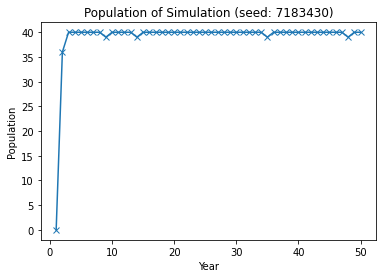

In [8]:
from neighborly.data_collection import DataTables
import matplotlib.pyplot as plt

import polars as pl

%matplotlib inline

data_tables = sim.world.resource_manager.get_resource(DataTables)
population_table = data_tables.get_data_frame("population")

first_of_the_month = population_table.filter(pl.col("month") == 1)

plt.plot(first_of_the_month["year"], first_of_the_month["population"], marker="x")
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(f"Population of Simulation (seed: {sim.config.seed})")


## Display histogram of character ages

(array([ 2.,  4.,  4.,  6., 16.,  5.,  1.,  0.,  1.,  1.]),
 array([ 26.,  36.,  46.,  56.,  66.,  76.,  86.,  96., 106., 116., 126.]),
 <BarContainer object of 10 artists>)

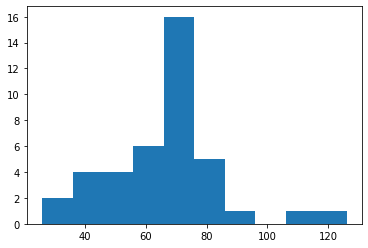

In [9]:
from neighborly.components.character import Character
from neighborly.ecs import Active


active_characters = sim.world.get_components((Active, Character))

ages = [int(character.age) for _, (_, character) in active_characters]

plt.hist(ages, bins=10)


(array([175.,   2.,   3.,   2.,   1.,   0.,   0.,   2.,   3.,   5., 823.,
          1.,   4.,   8.,   3.,   4.,   2.,   4.,   4., 292.]),
 array([-100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
         -10.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,
          80.,   90.,  100.]),
 <BarContainer object of 20 artists>)

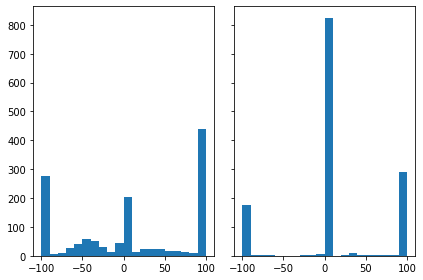

In [10]:
from neighborly.components.relationship import Relationship
from neighborly.components.stats import Stats
from neighborly.ecs import Active


active_relationships = sim.world.get_components((Active, Relationship, Stats))

reputation = [
    int(stats.get_stat("reputation").value) for _, (_, _, stats) in active_relationships
]

romance = [
    int(stats.get_stat("romance").value) for _, (_, _, stats) in active_relationships
]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(reputation, bins=20)
axs[1].hist(romance, bins=20)


In [11]:
from neighborly.components.character import Character
from neighborly.ecs import Active
from neighborly.life_event import PersonalEventHistory


active_characters = sim.world.get_components((Active, Character, PersonalEventHistory))

personal_histories = [list(history.history) for _, (_, _, history) in active_characters]

personal_story = "\n".join(str(entry) for entry in personal_histories[6])

print(personal_story)


Virginia Norrie(290) immigrated to Simple City(56).
Virginia Norrie(290) became an adult.
Virginia Norrie(290) became a senior.


In [12]:
from neighborly import inspection

# inspection.list_characters(sim)
inspection.inspect(sim, 146)
# inspection.list_traits(sim)
# inspection.list_settlements(sim)
# inspection.list_districts(sim)
# inspection.list_businesses(sim)
# inspection.list_characters(sim)

# inspection.print_sim_status(sim)



Relationship

UID: 146
Name: Magnus Chesnutt(116) -> Alena Warnes(96)(146)

Owner: Magnus Chesnutt(116)
Target: Alena Warnes(96)

=== Stats ===
Stat                      Value
----------------------  -------
reputation                  100
romance                       0
compatibility                 6
romantic_compatibility        0
interaction_score             1

=== Traits ===
Name    Description
------  -------------




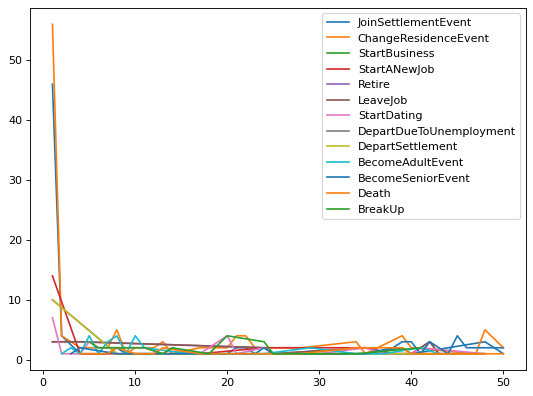

In [13]:
from neighborly.life_event import GlobalEventHistory

events = list(sim.world.resource_manager.get_resource(GlobalEventHistory))

event_bins: dict[str, dict[int, int]] = dict()

for event in events:
    event_type = event.__class__.__name__
    
    if event.__class__.__name__ not in event_bins:
        event_bins[event_type] = dict()
        
    if event.timestamp.year not in event_bins[event_type]:
        event_bins[event_type][event.timestamp.year] = 0
        
    event_bins[event_type][event.timestamp.year] += 1

    
plt.figure(figsize=(8, 6), dpi=80)

for entry, points in event_bins.items():
    plt.plot(points.keys(), points.values(), label=entry)
    
plt.legend(loc='upper right')

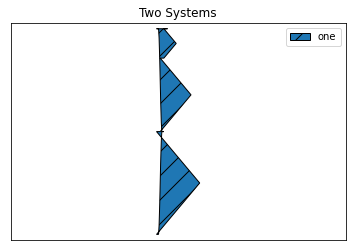

In [14]:
from matplotlib.sankey import Sankey

# Try to make a Sankey diagram centered on a single event type

def event_sankey_plot(
    simulation: Simulation, 
    event_type: str, 
    before: int = 3, 
    after: int = 3,
) -> None:
    """Create a sankey plot of the events leading to and following an event type."""
    
    prior_events: list[dict[str, int]] = []
    post_events = list[dict[str, int]] = []
    

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[], title="Two Systems")
flows = [2, 5 , 7]
sankey = Sankey(ax=ax, unit=None)
sankey.add(flows=flows, label='one',)
# sankey.add(flows=[-0.25, 0.15, 0.1], label='two',
#            orientations=[-1, -1, -1], prior=0, connect=(0, 0))
diagrams = sankey.finish()
diagrams[-1].patch.set_hatch('/')
plt.legend()